In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from numpy import linalg
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
import nltk
import pickle
from nltk import pos_tag
from scipy.sparse import hstack, vstack
from scipy import spatial
from sklearn.datasets import dump_svmlight_file,load_svmlight_file
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
import gensim
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import lightgbm as lgb
from sklearn import linear_model
import gc
import multiprocessing
import matplotlib.pyplot as plt
# 显示cell运行时长
%load_ext klab-autotime

In [5]:
# !killall python

In [2]:
train_lgb_feature = "/home/kesci/Text_CNN/train_lgb_counting_F.csv"
valid_lgb_feature = "/home/kesci/Text_CNN/valid_lgb_counting_F.csv"
test_lgb_feature = "/home/kesci/Text_CNN/test_lgb_counting_F.csv"
train_data = "/home/kesci/input/bytedance/first-round/train.csv"
test_data = "/home/kesci/input/bytedance/first-round/test.csv"


model_path = "/home/kesci/work/Text_CNN/"
colnames = ["query_id","query","query_title_id","title","label"]

time: 1.58 ms


In [3]:
######################### load dict
save_path = "/home/kesci/work/word2vec/wordvectors.kv"
word_vectors = KeyedVectors.load(save_path, mmap='r')
len(word_vectors["1427"])

######################## parameter
sentence_limit = 50
word_dim = 128
train_data_length = 5000000
samples = 100000000
chunksize = 5000000
skip_num = int(samples/chunksize) - 1
print(skip_num)

19
time: 8.14 s


In [4]:
##################### 0. 预处理embedding layer
import torch
from torch.utils.data import Dataset,DataLoader
cores = multiprocessing.cpu_count()-1

pre_emb_len = len(word_vectors.vocab.keys()) + 1
pre_emb_matrix = np.zeros((pre_emb_len,word_dim))
pre_reindex_dict = dict()   #常驻内存
reindex = 1
for key,_ in word_vectors.vocab.items():
    pre_emb_matrix[reindex] = word_vectors[key] #填充pretrained_emb
    pre_reindex_dict[key] = reindex #key:单词值 value:embedding index
    reindex += 1

print(pre_emb_matrix.shape,type(pre_emb_matrix))

(855707, 128) <class 'numpy.ndarray'>
time: 7.16 s


In [5]:
def get_seq_list(word_list):
    seq_list = np.zeros(sentence_limit)#序号0对应embedding层的零向量
    exits_word_count = 0
    for val in word_list:
        if exits_word_count > sentence_limit:
            break
        try:
            seq_list[exits_word_count] = pre_reindex_dict[val] #reindex
        except:
            continue  
        exits_word_count += 1
    return seq_list
    
class Dataset(torch.utils.data.Dataset):
    def __init__(self, sentence_f=None,other_f=None):
        self.sentence_d =  pd.read_csv(sentence_f,skiprows=chunksize*skip_num,nrows=chunksize,header=None,lineterminator="\n")
        self.other_d = pd.read_csv(other_f,header=None,lineterminator="\n")
    
    def __len__(self):
        return train_data_length
    
    def __getitem__(self, index):
        row = self.sentence_d.iloc[index]
        lgb_feature = self.other_d.iloc[index]
        query = get_seq_list(str(row[1]).split(" "))    
        title = get_seq_list(str(row[3]).split(" "))
        label = row[4]
        return query,title,label,lgb_feature


time: 4.02 ms


In [6]:
train_dataset = Dataset(train_data,train_lgb_feature)

time: 1min 17s


In [7]:
batch_size = 4096

def my_collate_padding(batch_list,dim2pad=0):
    """
    query,title,label分别进行padding操作(句子长度不是等长的)
    input: list of __getitem__ data
    output: merge data to batch
    """
    list_query,list_title,list_label,list_lgb_feature = zip(*batch_list)
    batch_size = len(batch_list) # 最后一个的batchsize是不完整的,这里的batchsize需要调整
    pad_query = np.zeros((batch_size, sentence_limit))
    pad_title = np.zeros((batch_size, sentence_limit))
    for i, tmp in enumerate(list_query):
        pad_query[i] = tmp
    for i, tmp in enumerate(list_title):
        pad_title[i] = tmp
    return pad_query,pad_title,np.array(list_label),np.array(list_lgb_feature)

time: 13.7 ms


In [8]:
train_data_generator = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,collate_fn=my_collate_padding,
                                          shuffle=True, sampler=None, batch_sampler=None, 
                                          num_workers=16, pin_memory=False, drop_last=False)

# dataloader_iterator = iter(train_data_generator)
# batch_q,batch_t,batch_l,batch_lgb = dataloader_iterator.next()
# print(batch_q.shape)
# print(batch_t.shape)
# print(batch_l.shape)
# print(batch_lgb.shape)
# print(batch_q[0])

time: 2.25 ms


In [9]:
# batch_q,batch_t,batch_l,batch_lgb = dataloader_iterator.next()
# print(batch_q.shape)
# print(batch_t.shape)
# print(batch_l.shape)
# print(batch_lgb.shape)
# print(batch_t[0])

time: 860 µs


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        
        in_channel = 1
        out_channel = 128
        class_num = 2
        dropout = 0.5
        Dim = word_dim
        kernel_list_q = [2,3,5]
        kernel_list_t = [2,3,5]
        other_feature_len = 49
        # pooling*3*（2=query+title），sim(3个pool) + lgb_feature
        last_linear_dim = out_channel*3*2 + 2*3 + other_feature_len
        
        # 0.embedding layer
        self.embed_layer = nn.Embedding(num_embeddings=pre_emb_len,embedding_dim=word_dim,sparse=False)
        self.embed_layer.weight.data.copy_(torch.from_numpy(pre_emb_matrix))
        self.embed_layer.weight.requires_grad = True #default
        
        # 1.CNN    #batch_normalize 对于训练集的效果很好
        self.cnn_parallel_query = nn.ModuleList([ nn.Sequential(
                                            nn.Conv2d(in_channel, out_channel, (K, Dim)),
                                            nn.BatchNorm2d(out_channel)
                                                            ) for K in kernel_list_q])
        self.cnn_parallel_title = nn.ModuleList([ nn.Sequential(
                                            nn.Conv2d(in_channel, out_channel, (K, Dim)),
                                            nn.BatchNorm2d(out_channel)
                                                    ) for K in kernel_list_t])
        # 2.Linear
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(last_linear_dim, class_num)

    def CNN_query(self,x):
        x = x.unsqueeze(1)  # (N, Ci, W, D)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.cnn_parallel_query]  # [(N, Co, W), ...]*len(Ks)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        return x
    
    def CNN_title(self,x):
        x = x.unsqueeze(1)  # (N, Ci, W, D)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.cnn_parallel_title]  # [(N, Co, W), ...]*len(Ks)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        return x
    
    def cosine_sim(self, query, title):
        l2_query = torch.norm(query,p=2,dim=1)
        l2_title = torch.norm(title,p=2,dim=1)
        sim_eud = torch.norm(query-title,p=2,dim=1) # 欧式距离 L2
        sim_cos = torch.sum(query * title,dim=1)/(l2_query * l2_title)
        return torch.cat((sim_cos.unsqueeze(1),sim_eud.unsqueeze(1)),dim=1)
    
    def forward(self, query,title,other_feature):
        query = self.CNN_query(self.embed_layer(query)) # [(N, Co), ...]*len(Ks)
        title = self.CNN_title(self.embed_layer(title)) # [(N, Co), ...]*len(Ks)
        sim_2dim = [self.cosine_sim(query[i],title[i]) for i in range(len(query))]
        pool_padding = torch.cat((tuple(query) + tuple(title) + tuple(sim_2dim) + tuple([other_feature])),dim=1)
        x = self.dropout(pool_padding)
        logit = self.fc1(x)  # (N, C)
        return logit


time: 10.2 ms


In [12]:
from torch.autograd import Variable
from numpy import linalg

def test_classify():
    x1 = torch.LongTensor(256,50).random_(0, 10)
    x2 = torch.LongTensor(256,50).random_(0, 10)
    other = torch.rand(256,49)
    
    model = CNN_Text()
    pre1 = model(x1,x2,other)
    print(pre1.shape)
#     print(pre1[0].shape,pre1[1].shape,pre1[-1].shape)
    return pre1
    
test = test_classify()
# print(test.shape)

torch.Size([256, 2])
time: 5.09 s


In [13]:
def plot(loss,mean_loss):
    from IPython import display
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.figure(figsize=(20,10))
    plt.clf()

    plt.title('Training...')
    plt.xlabel('iterator')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(mean_loss)
    plt.show()

time: 3.88 ms


<Figure size 1440x720 with 1 Axes>
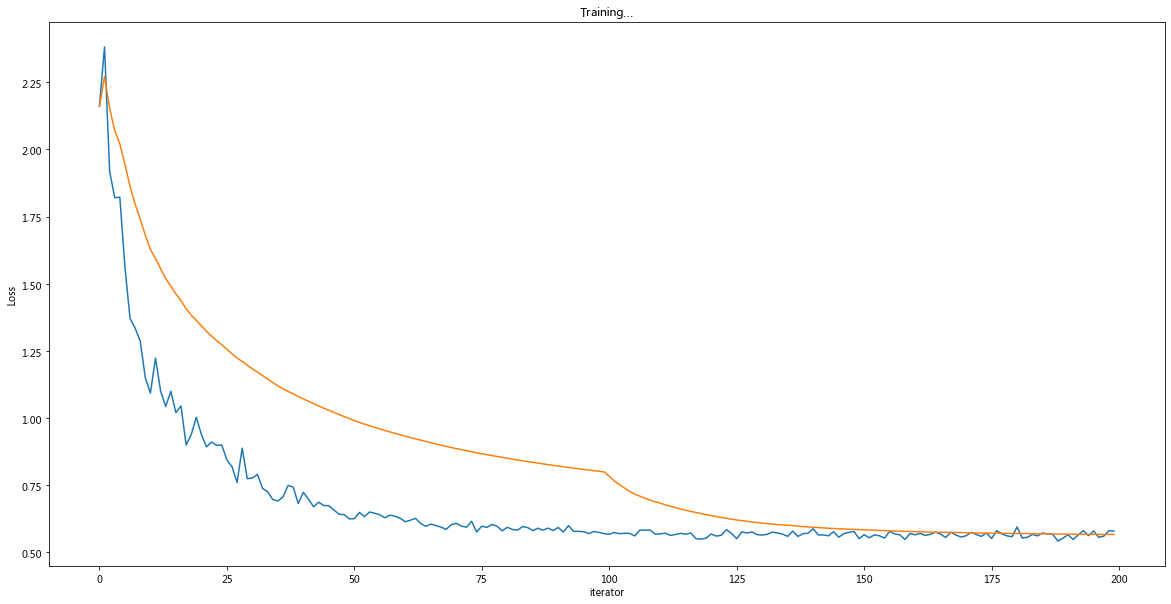

0.5657466143369675


<Figure size 1440x720 with 1 Axes>
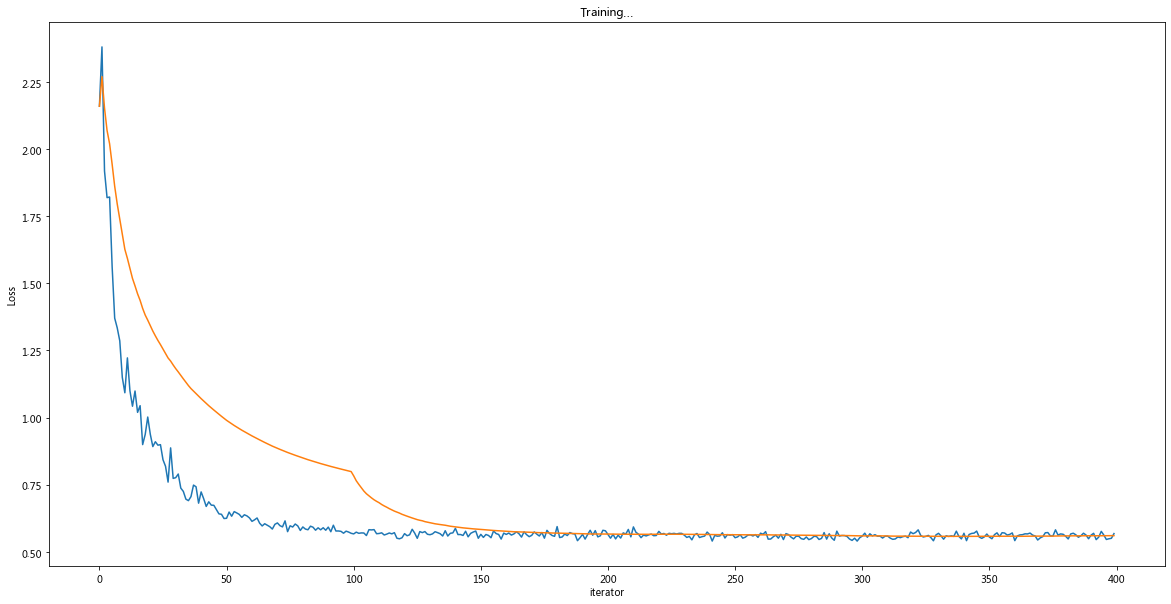

0.5598299282789231


<Figure size 1440x720 with 1 Axes>
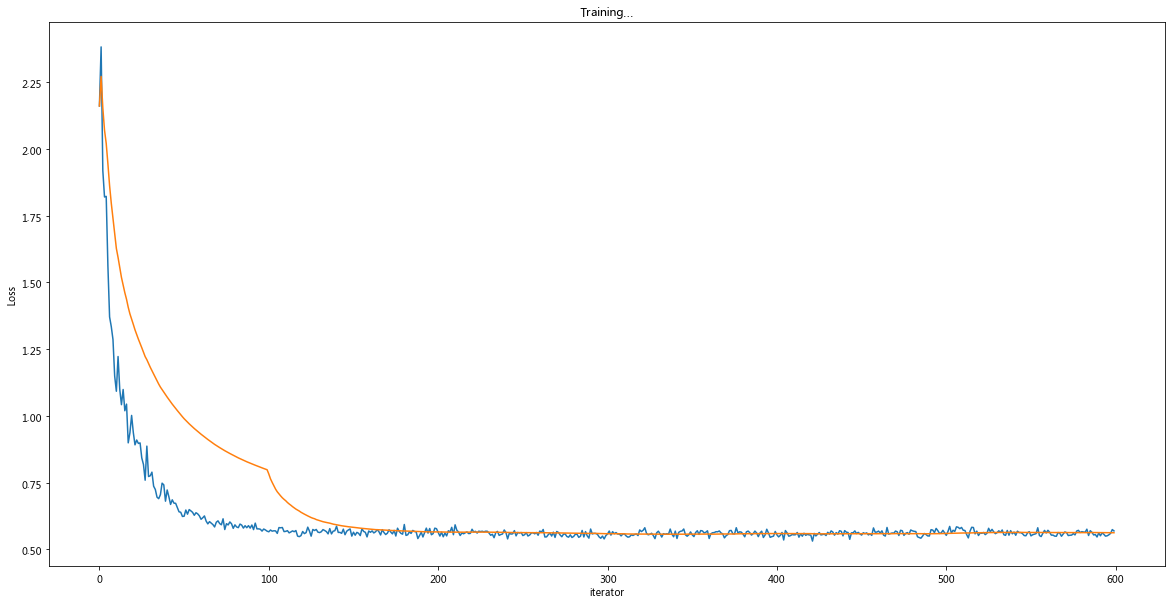

0.5626123982667923


<Figure size 1440x720 with 1 Axes>
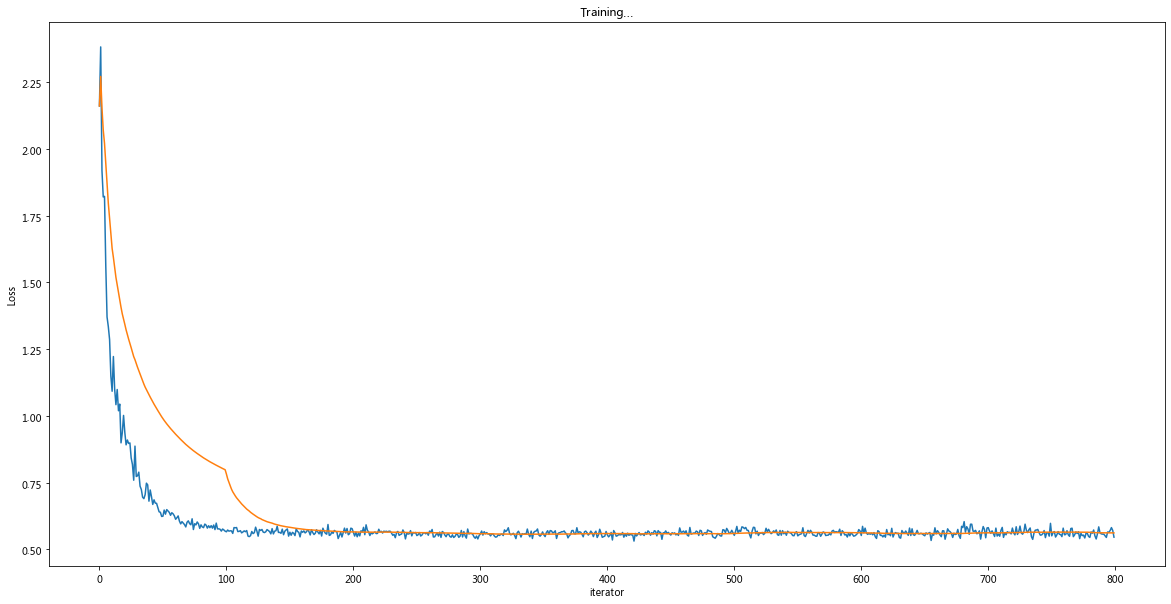

0.5619710087776184


<Figure size 1440x720 with 1 Axes>
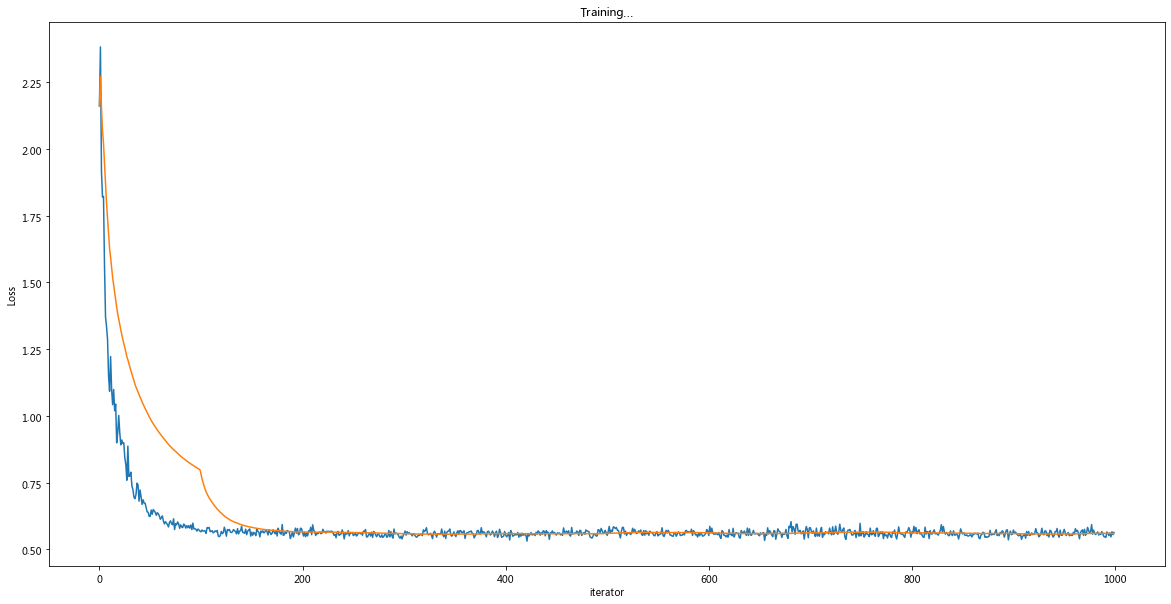

0.5601645272970199


<Figure size 1440x720 with 1 Axes>
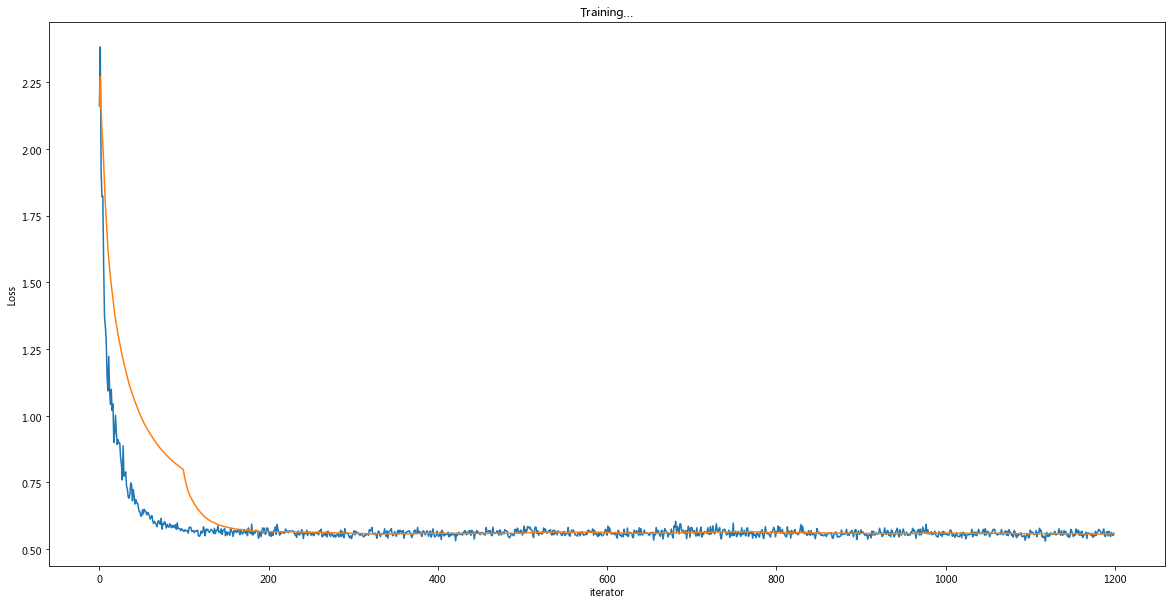

0.5580194824934006


<Figure size 1440x720 with 1 Axes>
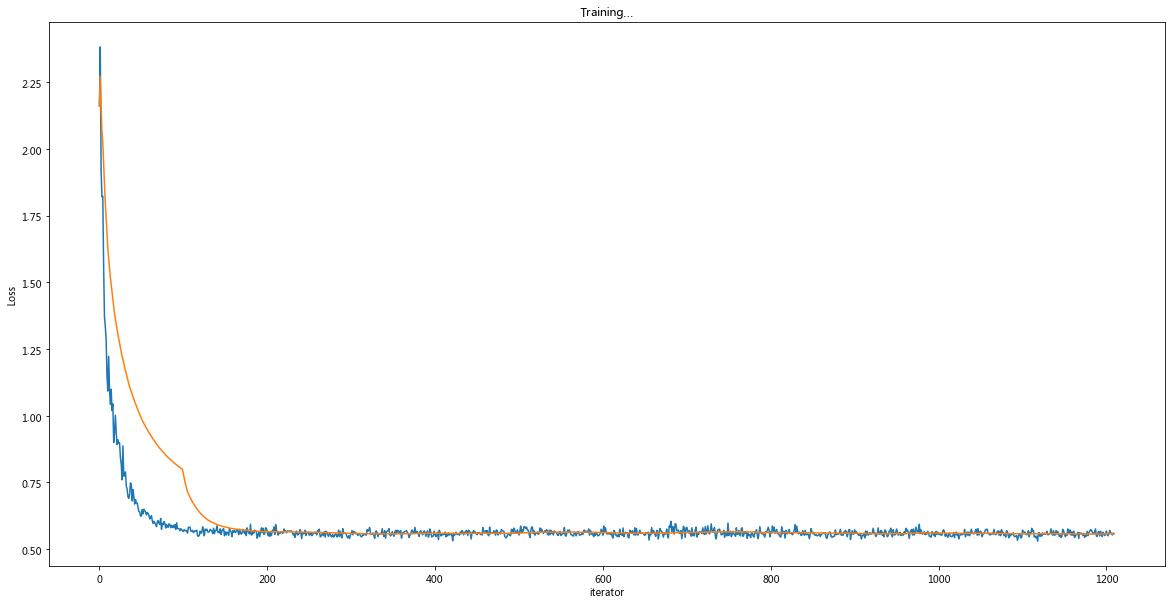

KeyboardInterrupt: 

In [18]:
############ 训练模型
import matplotlib.pyplot as plt
import torch.optim as optim
cnn_model = CNN_Text().float()
max_epochs = 1
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001,weight_decay=0.00001)
weight = [1,1]
class_weights = torch.FloatTensor(weight)
lossFunc = nn.CrossEntropyLoss(weight=class_weights)
cal_loss_list = []
cal_mean_loss_list = []

count = 0
for epoch in range(max_epochs):
    for batch_q,batch_t,batch_label,batch_lgb in train_data_generator:
        var_q = torch.from_numpy(batch_q).long()
        var_t = torch.from_numpy(batch_t).long()
        var_lgb = torch.from_numpy(batch_lgb).float()
        var_label = torch.from_numpy(batch_label)
        optimizer.zero_grad()
        outputs = cnn_model(var_q,var_t,var_lgb)
#         print(outputs)
#         break
        loss = lossFunc(outputs,var_label)
        loss.backward()
        optimizer.step()

        running_loss = loss.item()
        cal_loss_list.append(running_loss)
        count += 1
        if(count<100):
            cal_mean_loss_list.append(sum(cal_loss_list)/len(cal_loss_list))
        else:
            cal_mean_loss_list.append(sum(cal_loss_list[-100:])/100)
            
        if(count%10 == 0):
            plot(cal_loss_list,cal_mean_loss_list)
        
        if(count%200 == 0):
            torch.save(cnn_model.state_dict(),model_path+"text_CNN.model")
            print(cal_mean_loss_list[-1])

In [15]:
print(cal_mean_loss_list[-100:])

[0.5577515560388565, 0.5577618497610092, 0.5575959020853043, 0.5576310104131699, 0.5575306731462478, 0.5577572005987167, 0.5577990424633026, 0.5578567999601364, 0.5578731191158295, 0.5579174739122391, 0.5580215626955032, 0.557997767329216, 0.5578017711639405, 0.557904406785965, 0.5579352790117263, 0.5580561029911041, 0.5581177043914795, 0.5580035334825516, 0.5581944537162781, 0.5580985850095749, 0.5578897273540497, 0.5579553091526032, 0.5579396742582321, 0.5580267506837845, 0.5580015867948532, 0.5577737355232238, 0.5575626212358474, 0.5574778634309768, 0.5571981459856034, 0.5574081218242646, 0.5574626398086547, 0.5573544001579285, 0.5571934568881989, 0.5572753643989563, 0.5572026079893112, 0.5573755294084549, 0.5573329520225525, 0.5573005872964859, 0.5572809302806854, 0.5570563006401063, 0.5571159076690674, 0.5570527911186218, 0.557195121049881, 0.5570909690856933, 0.5570135575532913, 0.556947129368782, 0.5569603025913239, 0.5568505674600601, 0.5566692072153091, 0.5567464727163315, 0.5

In [16]:
print(cnn_model.state_dict())
torch.save(cnn_model.state_dict(),model_path+"text_CNN.model")
print('Finished Training')

OrderedDict([('embed_layer.weight', tensor([[ 8.5913e-02, -1.3500e-01, -1.1571e-01,  ..., -1.7016e-01,
          1.0489e-01,  1.0164e-02],
        [-2.5819e-02,  1.0290e-01,  2.7013e+00,  ..., -1.7738e+00,
         -2.3433e+00,  1.0231e+00],
        [ 8.9461e-01,  2.7043e-01,  2.0066e+00,  ...,  8.2963e-01,
         -9.3858e-01,  1.7966e+00],
        ...,
        [ 7.8880e-31,  8.0854e-32,  9.5505e-31,  ...,  1.7892e-30,
          8.2734e-31,  2.9795e-30],
        [-3.9862e-31,  1.6004e-31, -5.6575e-31,  ...,  3.6034e-29,
          3.3832e-30,  9.6462e-31],
        [ 1.2935e-30, -2.9379e-31, -2.3066e-29,  ..., -3.2185e-30,
          1.3451e-30, -2.2724e-30]])), ('cnn_parallel_query.0.0.weight', tensor([[[[-0.0497,  0.0248,  0.0133,  ..., -0.0267,  0.0763, -0.0032],
          [ 0.0392,  0.0363, -0.0017,  ...,  0.0431,  0.0296, -0.0115]]],


        [[[-0.0132, -0.0288, -0.0032,  ...,  0.0431,  0.0374, -0.0096],
          [-0.0079,  0.0061,  0.0127,  ..., -0.0175,  0.0474,  0.0048]]],




In [17]:
###########################  predict  #############
###########################  predict  #############
###########################  predict  #############
###########################  predict  #############
###########################  predict  #############
del train_dataset,train_data_generator
gc.collect()

5335

time: 1.24 s


In [18]:
import torch
from torch.utils.data import Dataset,DataLoader
class Dataset(torch.utils.data.Dataset):
    def __init__(self, sentence_f=None,other_f=None):
        self.sentence_d = pd.read_csv(sentence_f,header=None,lineterminator="\n")
        self.other_d = pd.read_csv(other_f,header=None,lineterminator="\n")
    
    def __len__(self):
        return train_data_length
    
    def __getitem__(self, index):
        row = self.sentence_d.iloc[index]
        lgb_feature = self.other_d.iloc[index]
        query = get_seq_list(str(row[1]).split(" "))    
        title = get_seq_list(str(row[3]).split(" "))
        return query,title,lgb_feature

time: 1.91 ms


In [19]:
test_dataset = Dataset(test_data,test_lgb_feature)

time: 1min 13s


In [20]:
batch_size = 4096

def my_collate_padding(batch_list,dim2pad=0):
    """
    query,title,label分别进行padding操作(句子长度不是等长的)
    input: list of __getitem__ data
    output: merge data to batch
    """
    list_query,list_title,list_lgb_feature = zip(*batch_list)
    batch_size = len(batch_list) # 最后一个的batchsize是不完整的,这里的batchsize需要调整
    pad_query = np.zeros((batch_size, sentence_limit))
    pad_title = np.zeros((batch_size, sentence_limit))
    for i, tmp in enumerate(list_query):
        pad_query[i] = tmp
    for i, tmp in enumerate(list_title):
        pad_title[i] = tmp
    return pad_query,pad_title,np.array(list_lgb_feature)
    
test_data_generator = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,collate_fn=my_collate_padding,
                                          shuffle=False, sampler=None, batch_sampler=None, 
                                          num_workers=16, pin_memory=False, drop_last=False)

time: 5.79 ms


In [21]:
print(cal_mean_loss_list[-10:])

############ 2019.6.29 LOSS
# [0.562483719587326, 0.5626659923791886,
# 0.5626803404092788, 0.5627972543239593, 0.5629454910755157, 0.5633597022294998,
# 0.5635562831163407, 0.5634854000806808, 0.563582819700241, 0.5635741877555848]

[0.5578777414560318, 0.5578215384483337, 0.5575885897874833, 0.5573790043592453, 0.5572819006443024, 0.557610200047493, 0.5579422891139985, 0.5580430209636689, 0.5581451147794724, 0.5586130595207215]
time: 1.89 ms


In [22]:
import time
test_model = CNN_Text().float()
state_dict = torch.load(model_path+"text_CNN.model")
test_model.load_state_dict(state_dict)
test_model = test_model.eval()

ans = []
count = 0
stime=time.time()
with torch.no_grad():
    for batch_q,batch_t,batch_lgb in test_data_generator:
        var_q = torch.from_numpy(batch_q).long()
        var_t = torch.from_numpy(batch_t).long()
        var_lgb = torch.from_numpy(batch_lgb).float()
        predict = test_model(var_q,var_t,var_lgb)
        predict = F.softmax(predict,dim=1).detach().cpu()
        ans.extend(predict[:,1].data.tolist())
        if count%100 == 0:
            print(time.time()-stime)
            stime=time.time()
        count += 1
print(len(ans))
print(ans[:10])

48.66741633415222
753.9146270751953
745.8681683540344
743.8119513988495
757.1853048801422
767.8015100955963
749.5303406715393
737.5755414962769
727.1142220497131
739.6942148208618
767.8989608287811
791.8902196884155
793.7892000675201
5000000
[0.26866522431373596, 0.2892260253429413, 0.2964988648891449, 0.2773776054382324, 0.337327241897583, 0.34655261039733887, 0.32616132497787476, 0.19430097937583923, 0.21753977239131927, 0.20274735987186432]
time: 2h 34min 29s


In [24]:
np_ans = np.array(ans)
for i in ~np.isfinite(np_ans):
    if i:
        print(i)
np_ans[~np.isfinite(np_ans)] = 0
print(np_ans.shape)
print(np.average(np_ans))

(5000000,)
0.26626853118492605
time: 607 ms


In [25]:
predict_ans = ans
colnames = ["query_id","query","query_title_id","title"]
test_df = pd.read_csv(test_data,names=colnames, header=None,lineterminator="\n")
test_df["pred"] = predict_ans
print(test_df.shape)

save_path = "/home/kesci/submit/"
test_df.to_csv(save_path+"500w_NN_pre_embedding_layer.csv",columns=["query_id","query_title_id","pred"],header=None,index=None)
del test_df
gc.collect()

(5000000, 5)


21

time: 36.5 s


In [28]:
!cat /home/kesci/submit/500w_NN_pre_embedding_layer.csv | wc -l
!cat /home/kesci/submit/500w_NN_pre_embedding_layer.csv | head -n 5
# !cat /home/kesci/submit/500w_NN.csv | head -n 5


5000000
1,3,0.26866522431373596
1,1,0.2892260253429413
1,4,0.2964988648891449
1,2,0.2773776054382324
2,1,0.337327241897583
cat: write error: Broken pipe
time: 2.09 s


In [29]:
!./kesci_submit -token d0370b8fc0402430 -file /home/kesci/submit/500w_NN_pre_embedding_layer.csv

Kesci Submit Tool
Result File: /home/kesci/submit/500w_NN_pre_embedding_layer.csv (135.82 MiB)
Uploaded.       
Submit Success.
{"Stage":0,"Status":0,"ShownInHistory":true,"IsAucResult":true,"Selected":false,"_id":"5d182354d5eca3002cc2e291","Competition":"5cc51043f71088002c5b8840","Team":"5cf232b52e1a1d002b39155e","UploadDate":"2019-06-30T02:49:56.203Z","Final":true,"Response":"","SubmissionResults":[],"IP":"52.82.19.99","FingerPrint":"","UserAgent":"Go-http-client/1.1","ResultFileName":"1561862983044d47b6a.csv","ResultFileRealName":"500w_NN_pre_embedding_layer.csv","ResultFileSize":0,"ReviewInfos":[],"__v":0}

time: 15.1 s


In [52]:
################## 融合LGB predict(with rank feature)  #############
################## 融合LGB predict(with rank feature)  #############
################## 融合LGB predict(with rank feature)  #############
################## 融合LGB predict(with rank feature)  #############


colnames = ["qid","tid","predict"]
save_path = "/home/kesci/submit/"
path1 = save_path+"500w_NN_pre_embedding_layer.csv"
path2 = save_path+"500w_lgb_300_trees.csv"
pred1 = pd.read_csv(path1, names=colnames,header=None,lineterminator="\n")["predict"]
pred2 = pd.read_csv(path2, names=colnames,header=None,lineterminator="\n")["predict"]
print(pred1.shape,pred2.shape)
print(np.average(pred1))
print(np.average(pred2))

(5000000,) (5000000,)
0.26626853118492605
0.5249509840475696
time: 3.87 s


In [53]:
pred1 = np.array(pred1) * (0.55018100/(0.55018100+0.59236600)) 
pred2 = np.array(pred2) * (0.59236600/(0.55018100+0.59236600)) 
avg_pred = pred1+pred2
print(np.average(pred1))
print(np.average(pred2))
print(np.average(avg_pred),avg_pred.shape)

0.1282186962600698
0.2721665844961498
0.4003852807562196 (5000000,)
time: 131 ms


In [54]:
colnames = ["query_id","query","query_title_id","title"]
test_df = pd.read_csv(test_data,names=colnames, header=None,lineterminator="\n")
test_df["pred"] = avg_pred
print(test_df.shape)

save_path = "/home/kesci/submit/"
test_df.to_csv(save_path+"500w_ensemble_2_NN_lgb_with_embedding_layer.csv",columns=["query_id","query_title_id","pred"],header=None,index=None)
del test_df
gc.collect()

(5000000, 5)


21

time: 36.7 s


In [55]:
!cat /home/kesci/submit/500w_ensemble_NN_lgb_with_embedding_layer.csv | wc -l
!cat /home/kesci/submit/500w_ensemble_NN_lgb_with_embedding_layer.csv | head -n 5
!cat /home/kesci/submit/500w_ensemble_2_NN_lgb_with_embedding_layer.csv | head -n 5

5000000
1,3,0.46291465004088067
1,1,0.48584153780361783
1,4,0.48907909046437836
1,2,0.4819427483226676
2,1,0.552745489132946
cat: write error: Broken pipe
1,3,0.46139982186906014
1,1,0.48430825802079513
1,4,0.4875772793267399
1,2,0.4803474744099967
2,1,0.5510655787372535
cat: write error: Broken pipe
time: 3.28 s


In [56]:
!./kesci_submit -token d0370b8fc0402430 -file /home/kesci/submit/500w_ensemble_2_NN_lgb_with_embedding_layer.csv

Kesci Submit Tool
Result File: /home/kesci/submit/500w_ensemble_2_NN_lgb_with_embedding_layer.csv (134.88 MiB)
Uploaded.       
Submit Success.
{"Stage":0,"Status":0,"ShownInHistory":true,"IsAucResult":true,"Selected":false,"_id":"5d1824f1c69214002c40fe6c","Competition":"5cc51043f71088002c5b8840","Team":"5cf232b52e1a1d002b39155e","UploadDate":"2019-06-30T02:56:49.643Z","Final":true,"Response":"","SubmissionResults":[],"IP":"52.82.19.99","FingerPrint":"","UserAgent":"Go-http-client/1.1","ResultFileName":"156186339640073ee4c.csv","ResultFileRealName":"500w_ensemble_2_NN_lgb_with_embedding_layer.csv","ResultFileSize":0,"ReviewInfos":[],"__v":0}

time: 15.1 s


In [57]:
!cp  /home/kesci/submit/* /home/kesci/work/submit_tmp/

time: 3.12 s
